# 1. Getting Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from sklearn.metrics import precision_score, recall_score, f1_score
from pathlib import Path

# 2. Get Data

In [ ]:
# Dataset Preparation and Preprocessing
# Data Transformations (You can customize these)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=r"C:\Users\peer1\.cache\kagglehub\datasets\vipoooool\new-plant-diseases-dataset\versions\2\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train", transform=train_transform)
val_dataset = ImageFolder(root=r"C:\Users\peer1\.cache\kagglehub\datasets\vipoooool\new-plant-diseases-dataset\versions\2\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\valid", transform=val_transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

# 4. Developing and Training CustomCNN Model

In [5]:
# Define the Custom CNN model
class PlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseCNN, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Assuming input size is 224x224
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        
        # Flatten for Fully Connected layers
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Set number of classes
num_classes = 38  # Change based on the dataset
model = PlantDiseaseCNN(num_classes=num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Validation Loops
def train(model, train_loader, val_loader, optimizer, loss_fn, epochs=25):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        train_correct = 0
        total = 0
        all_train_preds = []
        all_train_labels = []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
        
        train_acc = 100 * train_correct / total
        train_precision = precision_score(all_train_labels, all_train_preds, average='weighted')
        train_recall = recall_score(all_train_labels, all_train_preds, average='weighted')
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")

        # Validation
        val_loss, val_acc, val_precision, val_recall, val_f1 = validate(model, val_loader, loss_fn)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, Validation F1: {val_f1:.4f}")

def validate(model, val_loader, loss_fn):
    model.eval()
    val_loss = 0
    val_correct = 0
    total = 0
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())
    
    val_acc = 100 * val_correct / total
    val_precision = precision_score(all_val_labels, all_val_preds, average='weighted')
    val_recall = recall_score(all_val_labels, all_val_preds, average='weighted')
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
    return val_loss, val_acc, val_precision, val_recall, val_f1

# Train the custom CNN model
train(model=model, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=25)


Epoch 1/25, Train Loss: 7395.2756, Train Accuracy: 9.58%, Train Precision: 0.1091, Train Recall: 0.0958, Train F1: 0.0922


c:\Users\peer1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 1453.0205, Validation Accuracy: 23.07%, Validation Precision: 0.2030, Validation Recall: 0.2307, Validation F1: 0.1466
Epoch 2/25, Train Loss: 2574.0685, Train Accuracy: 62.83%, Train Precision: 0.6216, Train Recall: 0.6283, Train F1: 0.6210
Validation Loss: 438.3533, Validation Accuracy: 74.82%, Validation Precision: 0.7695, Validation Recall: 0.7482, Validation F1: 0.7438
Epoch 3/25, Train Loss: 1167.0590, Train Accuracy: 82.65%, Train Precision: 0.8253, Train Recall: 0.8265, Train F1: 0.8254
Validation Loss: 236.8491, Validation Accuracy: 85.97%, Validation Precision: 0.8675, Validation Recall: 0.8597, Validation F1: 0.8581
Epoch 4/25, Train Loss: 818.3870, Train Accuracy: 87.71%, Train Precision: 0.8765, Train Recall: 0.8771, Train F1: 0.8766
Validation Loss: 188.9417, Validation Accuracy: 88.89%, Validation Precision: 0.8976, Validation Recall: 0.8889, Validation F1: 0.8897
Epoch 5/25, Train Loss: 647.2231, Train Accuracy: 90.32%, Train Precision: 0.9029, Train Re

# 5. Saving the Model

In [3]:
# 1. create models directory
model_path = Path(r"C:\Users\peer1\OneDrive\Documents\Guvi_Projects\Final Project\Plant disease detection")
model_path.mkdir(parents=True, exist_ok=True)

# 2. create model save path
model_name = "CustomPrediction_model.pth"
model_save_path = model_path / model_name

# 3. save the model state dict
print(f"Saving model to: {model_save_path}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=model_save_path)

Saving model to: C:\Users\peer1\OneDrive\Documents\Guvi_Projects\Final Project\Plant disease detection\CustomPrediction_model.pth


# 6. Testing the Model to make predictions

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the Custom CNN model
class PlantDiseaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseCNN, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Assuming input size is 224x224
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        # Flatten for Fully Connected layers
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Set number of classes
num_classes = 38  # Change based on the dataset
model = PlantDiseaseCNN(num_classes=num_classes)

# Load the saved model state dictionary
model_path = r"C:\Users\peer1\OneDrive\Documents\Guvi_Projects\Final Project\Plant disease detection\CustomPrediction_model.pth"
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# prediction function on single image
def predict_image(image_path, model):
        # open and preprocess the image
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    image = image.to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
        predicted_label = predicted.item()

    # Define class labels (replace with your actual class labels)
    class_labels =train_dataset.classes

    # Display the image with prediction and confidence
    plt.imshow(Image.open(image_path))
    plt.title(f"Prediction: {class_labels[predicted_label]}, Confidence: {confidence[predicted_label]:.2f}%")
    plt.axis("off")
    plt.show()


C:\Users\peer1\AppData\Local\Temp\ipykernel_26916\3929853142.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=t

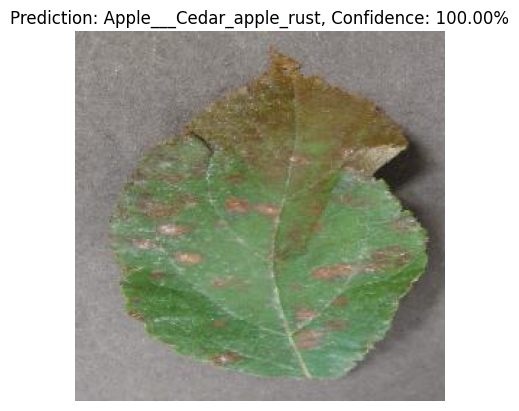

In [19]:
# apple cedar rust prediction
image_path = r"C:\Users\peer1\.cache\kagglehub\datasets\vipoooool\new-plant-diseases-dataset\versions\2\test\test\AppleCedarRust4.JPG"
predict_image(image_path, model)

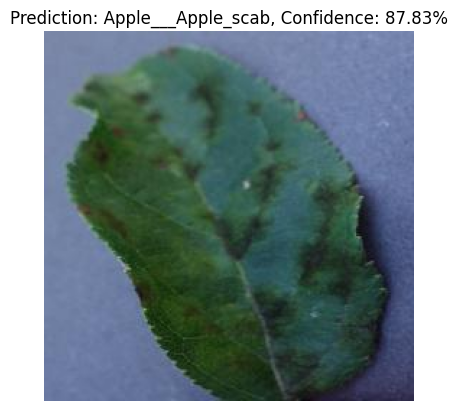

In [20]:
# apple scab prediction
image_path = r"C:\Users\peer1\.cache\kagglehub\datasets\vipoooool\new-plant-diseases-dataset\versions\2\test\test\AppleScab2.JPG"
predict_image(image_path, model)

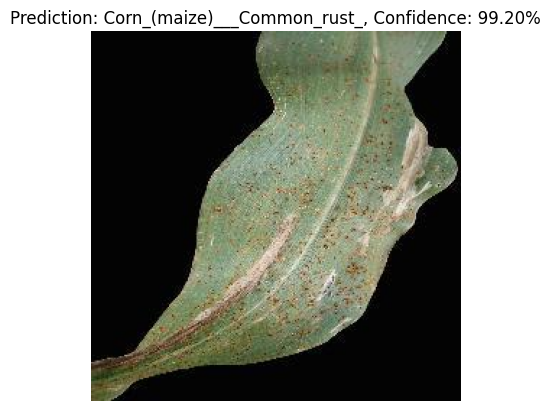

In [21]:
# corn common rust prediction
image_path = r"C:\Users\peer1\.cache\kagglehub\datasets\vipoooool\new-plant-diseases-dataset\versions\2\test\test\CornCommonRust1.JPG"
predict_image(image_path, model)

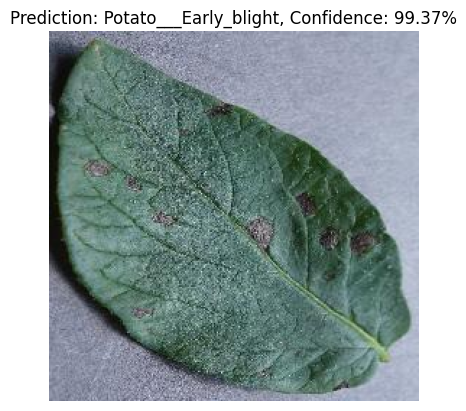

In [22]:
# potato early blight prediction
image_path = r"C:\Users\peer1\.cache\kagglehub\datasets\vipoooool\new-plant-diseases-dataset\versions\2\test\test\PotatoEarlyBlight3.JPG"
predict_image(image_path, model)

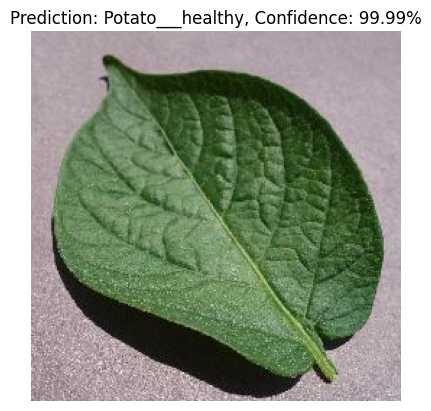

In [23]:
# potato healthy prediction
image_path = r"C:\Users\peer1\.cache\kagglehub\datasets\vipoooool\new-plant-diseases-dataset\versions\2\test\test\PotatoHealthy1.JPG"
predict_image(image_path, model)

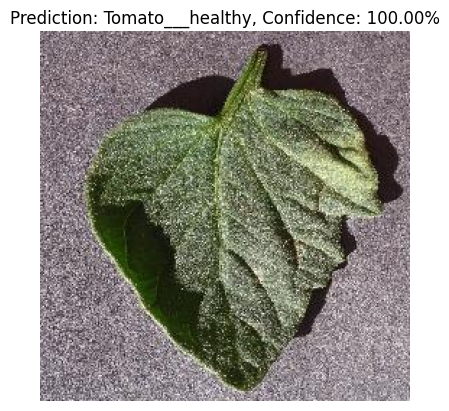

In [25]:
# tomato healthy prediction
image_path = r"C:\Users\peer1\.cache\kagglehub\datasets\vipoooool\new-plant-diseases-dataset\versions\2\test\test\TomatoHealthy1.JPG"
predict_image(image_path, model)

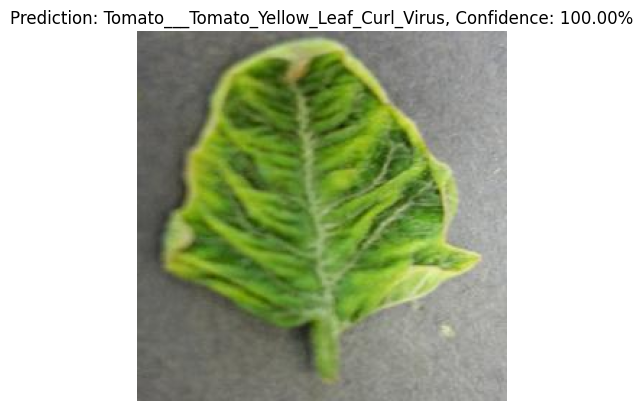

In [26]:
# tomato yellow curl virus prediction
image_path = r"C:\Users\peer1\.cache\kagglehub\datasets\vipoooool\new-plant-diseases-dataset\versions\2\test\test\TomatoYellowCurlVirus6.JPG"
predict_image(image_path, model)

The prediction results on several test images show that the trained CustomCNN Model can predict all of them correctly. Furthermore, the model can be used for further deployment stages for production purposes. Thus, the plant disease classification experiment has been completed. From these results, it can be concluded that the use model is very effective and efficient for completing computer vision tasks in general. More specifically, the  model has good performance for image classification tasks.